In [1]:
"""
Created on Wed Feb 26 17:01:56 2020

"""

""" IMPORTS """
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #CPU ONLY
import numpy as np
sys.path.append("../")
np.random.seed(1337)  # for reproducibility
import tensorflow as tf
tf.config.experimental.set_visible_devices([],"GPU")
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.datasets import mnist
from tensorflow.keras.constraints import *
from sklearn.model_selection import train_test_split
# from keras.utils import np_utils

from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, BinaryConv2D

import h5py
from pathlib import Path
import scipy.io as sio



from lambda_layers import *
from binary_ops import *
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3419102461533259132
]


In [2]:
""" FUNCTIION AND VARIABLE DEFINITIONS """

hdf5_dir = Path("../../data/")

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read
        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images= []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_vids.hdf", "r+")

    images = np.array(file["/data"]).astype("float32")

    return images

"""import x and y """

#ptm = "../../../../MATLAB/CUP Imaging with TwIST/CUP Imaging with TwIST/"
ptm = "D:/Matt/"
ball_vids = h5py.File(ptm+'full_sized_1.hdf','r')
ball_vids = np.asarray(ball_vids['data'])
ball_vids = np.transpose(ball_vids,(0,3,1,2))
ims = np.reshape(ball_vids,(100,100,256,256,1))
validate = h5py.File(ptm+'full_ball_vids.h5','r')
validate = np.asarray(validate['data'])
validate = np.transpose(validate,(0,3,1,2))
validate = validate - np.min(validate)
validate = np.reshape(validate,(100,100,256,256,1))


MX_train, MX_test, My_train, My_test = train_test_split(validate,ims, test_size = 0.3, random_state = 42)

print(np.shape(MX_test))
print(np.shape(MX_train))


reduce_lr = ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=0.5,
                              patience=20, min_lr=1e-7)
early_stopping = EarlyStopping(patience=90,verbose=1,restore_best_weights=True)   


def custom_loss(y_true, y_pred):

  ssim_loss = (1.0-tf.image.ssim(y_true,y_pred,1))/2.0
  mse_loss = K.mean(K.square(y_pred-y_true))
  #mse_loss = tf.keras.losses.mean_squared_error(y_true,y_pred)

  ssim_loss = 0.5*ssim_loss
  mse_loss = 0.5*mse_loss

  return ssim_loss + mse_loss

def ssim_loss(y_true,y_pred):  
    return (1.0-tf.image.ssim(y_true,y_pred,1))/2.0

def mse_loss(y_true,y_pred):
    return K.mean(K.square(y_pred-y_true))

(30, 100, 256, 256, 1)
(70, 100, 256, 256, 1)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [9]:
""" 
UNET MODEL (NO BATCH NORM)
Fixing the weights for the bin_conv1 layer as well as the dense1 layer, ie NON TRAINABLE
Feeding in weights from the forward_model above to see if that improves the results from previous session

"""

inputs = Input(shape=(100,256,256,1))
c1 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (inputs)
c1 = Dropout(0.1) (c1)
c1 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c1)
p1 = TimeDistributed(MaxPooling2D((2, 2)))(c1)

c2 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p1)
c2 = Dropout(0.1) (c2)
c2 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c2)
p2 = TimeDistributed(MaxPooling2D((2, 2)) )(c2)

c3 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(p2)
c3 = Dropout(0.2) (c3)
c3 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c3)
p3 = TimeDistributed(MaxPooling2D((2, 2)) )(c3)

c4 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(p3)
c4 = Dropout(0.2) (c4)
c4 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c4)
p4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2))) (c4)

c5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (p4)
c5 = Dropout(0.3) (c5)
c5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c5)

u6 = TimeDistributed(Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'))(c5)
u6 = concatenate([u6, c4])
c6 = TimeDistributed( Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(u6)
c6 = Dropout(0.2) (c6)
c6 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c6)

u7 = TimeDistributed(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') )(c6)
u7 = concatenate([u7, c3])
c7 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u7)
c7 = Dropout(0.2) (c7)
c7 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c7)
    
u8 = TimeDistributed(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') )(c7)
u8 = concatenate([u8, c2])
c8 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u8)
c8 = Dropout(0.1) (c8)
c8 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c8)

u9 = TimeDistributed(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')) (c8)
c9 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u9)
c9 = Dropout(0.1) (c9)
c9 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c9)
    
outputs = TimeDistributed(Conv2D(1, (1, 1), activation='sigmoid')) (c9)

CUPNET2 = Model(inputs = [inputs], outputs = [outputs])
    
CUPNET2.compile(optimizer = Nadam(), loss = custom_loss, metrics = [ssim_loss,mse_loss])
CUPNET2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed_27 (TimeDistri (None, 100, 256, 256 320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 100, 256, 256 0           time_distributed_27[0][0]        
__________________________________________________________________________________________________
time_distributed_28 (TimeDistri (None, 100, 256, 256 9248        dropout_9[0][0]                  
____________________________________________________________________________________________

In [3]:
""" 
UNET MODEL
Fixing the weights for the bin_conv1 layer as well as the dense1 layer, ie NON TRAINABLE
Feeding in weights from the forward_model above to see if that improves the results from previous session

"""
inputs = Input(shape=(100,256,256,1))
c1 = TimeDistributed(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (inputs)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.1) (c1)
c1 = TimeDistributed(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c1)
c1 = BatchNormalization() (c1)
p1 = TimeDistributed(MaxPooling2D((2, 2)))(c1)

c2 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p1)
c2 = BatchNormalization() (c2)
c2 = Dropout(0.1) (c2)
c2 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c2)
c2 = BatchNormalization() (c2)
p2 = TimeDistributed(MaxPooling2D((2, 2)) )(c2)

c3 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(p2)
c3 = BatchNormalization() (c3)
c3 = Dropout(0.2) (c3)
c3 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c3)
c3 = BatchNormalization() (c3)
p3 = TimeDistributed(MaxPooling2D((2, 2)) )(c3)

c4 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(p3)
c4 = BatchNormalization() (c4)
c4 = Dropout(0.2) (c4)
c4 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(c4)
c4 = BatchNormalization() (c4)
p4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2))) (c4)

c5 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (p4)
c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c5)
c5 = BatchNormalization() (c5)

u6 = TimeDistributed(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))(c5)
u6 = concatenate([u6, c4])
c6 = TimeDistributed( Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') )(u6)
c6 = BatchNormalization() (c6)
c6 = Dropout(0.2) (c6)
c6 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c6)
c6 = BatchNormalization() (c6)

u7 = TimeDistributed(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') )(c6)
u7 = concatenate([u7, c3])
c7 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u7)
c7 = BatchNormalization() (c7)
c7 = Dropout(0.2) (c7)
c7 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c7)
c7 = BatchNormalization() (c7)
    
u8 = TimeDistributed(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') )(c7)
u8 = concatenate([u8, c2])
c8 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u8)
c8 = BatchNormalization() (c8)
c8 = Dropout(0.1) (c8)
c8 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c8)
c8 = BatchNormalization() (c8)

u9 = TimeDistributed(Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')) (c8)
c9 = TimeDistributed(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (u9)
c9 = BatchNormalization() (c9)
c9 = Dropout(0.1) (c9)
c9 = TimeDistributed(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')) (c9)
c9 = BatchNormalization() (c9)
    
outputs = TimeDistributed(Conv2D(1, (1, 1), activation='sigmoid')) (c9)

CUPNET2 = Model(inputs = [inputs], outputs = [outputs])
    
CUPNET2.compile(optimizer = Nadam(), loss = custom_loss, metrics = [ssim_loss,mse_loss],callbacks=[reduce_lr, early_stopping])
CUPNET2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 256, 25 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 100, 256, 256 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 256, 256 64          time_distributed[0][0]           
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 256, 256 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
checkpoint_filepath = "D:/Matt/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch')

In [5]:
CUPNET2.save_weights("D:/Matt/FULLCUPNET_WEIGHTS.h5")

In [16]:
CUPNET2_history = CUPNET2.fit(MX_train, My_train,
          batch_size = 2,epochs= 15,
          verbose=1,validation_data=(MX_test,My_test),callbacks=[reduce_lr,early_stopping,model_checkpoint_callback])

Train on 70 samples, validate on 30 samples
Epoch 1/15
70/70 [==============================] - 4836s 69s/sample - loss: 0.0817 - ssim_loss: 0.0936 - mse_loss: 0.0698 - val_loss: 0.1010 - val_ssim_loss: 0.1225 - val_mse_loss: 0.0795
Epoch 2/15
70/70 [==============================] - 4796s 69s/sample - loss: 0.0804 - ssim_loss: 0.0928 - mse_loss: 0.0680 - val_loss: 0.1343 - val_ssim_loss: 0.1711 - val_mse_loss: 0.0975
Epoch 3/15
70/70 [==============================] - 4807s 69s/sample - loss: 0.0800 - ssim_loss: 0.0925 - mse_loss: 0.0675 - val_loss: 0.1206 - val_ssim_loss: 0.1448 - val_mse_loss: 0.0964
Epoch 4/15
70/70 [==============================] - 4804s 69s/sample - loss: 0.0790 - ssim_loss: 0.0913 - mse_loss: 0.0666 - val_loss: 0.1102 - val_ssim_loss: 0.1426 - val_mse_loss: 0.0779
Epoch 5/15
70/70 [==============================] - 4850s 69s/sample - loss: 0.0781 - ssim_loss: 0.0906 - mse_loss: 0.0656 - val_loss: 0.1476 - val_ssim_loss: 0.1835 - val_mse_loss: 0.1117
Epoch 6/15


In [17]:
CUPNET2.save_weights("D:/Matt/FULLCUPNET_WEIGHTS_first_45_5_22.h5")

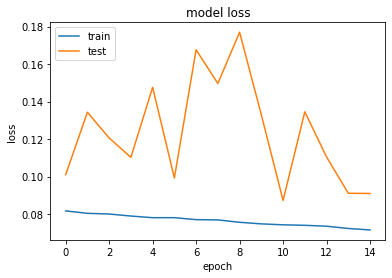

In [60]:
plt.plot(CUPNET2_history.history['loss'])
plt.plot(CUPNET2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
#y_train_pred = CUPNET2.predict(MX_train)
y_test_pred3 = CUPNET2.predict(np.reshape(MX_test[:3],(3,100,256,256,1)),verbose=1)
y_test_pred6 = CUPNET2.predict(np.reshape(MX_test[3:6],(3,100,256,256,1)),verbose=1)
y_test_pred9 = CUPNET2.predict(np.reshape(MX_test[6:9],(3,100,256,256,1)),verbose=1)
y_test_pred12 = CUPNET2.predict(np.reshape(MX_test[9:12],(3,100,256,256,1)),verbose=1)
y_test_pred15 = CUPNET2.predict(np.reshape(MX_test[12:15],(3,100,256,256,1)),verbose=1)
y_test_pred18 = CUPNET2.predict(np.reshape(MX_test[15:18],(3,100,256,256,1)),verbose=1)
y_test_pred21 = CUPNET2.predict(np.reshape(MX_test[18:21],(3,100,256,256,1)),verbose=1)
y_test_pred24 = CUPNET2.predict(np.reshape(MX_test[21:24],(3,100,256,256,1)),verbose=1)
y_test_pred27 = CUPNET2.predict(np.reshape(MX_test[24:27],(3,100,256,256,1)),verbose=1)
y_test_pred30 = CUPNET2.predict(np.reshape(MX_test[27:],(3,100,256,256,1)),verbose=1)

3/1 [==========================================================================================] - 35s 12s/sample


In [21]:
test_preds = np.concatenate([y_test_pred3,y_test_pred6,y_test_pred9,y_test_pred12,y_test_pred15,y_test_pred18,y_test_pred21,y_test_pred24,y_test_pred27,y_test_pred30])

In [22]:
np.save('D:/Matt/full_test_preds',test_preds)

In [26]:
test_preds = test_preds.astype('float32')
My_test = My_test.astype('float32')
ssims = []
for i in range(30):
    ssim_l = np.mean(tf.image.ssim(tf.convert_to_tensor(test_preds[i]),tf.convert_to_tensor(My_test[i]),1))
    ssims.append(ssim_l)

In [27]:
min_ssim_ind = np.argmin(ssims)
max_ssim_ind = np.argmax(ssims)

In [ ]:
npdir = "D:/Matt/"
np.save(npdir+'ball_lsqr_test_predictions',y_test_pred)
np.save(npdir+'ball_lsqr_train_predictions',y_train_pred)
np.save(npdir+'ball_lsqr_training_ims',My_train)
np.save(npdir+'ball_lsqr_test_ims',My_test)

In [49]:
def show_video(y_pred,y_true,num,save=False,filename = 'test.png'):
    yp = np.reshape(y_pred,(-1,100,256,256))
    yt = np.reshape(y_true,(-1,100,256,256))
    split = np.zeros((5,256,256))
    yp_tensor = tf.convert_to_tensor(y_pred[num])
    yt_tensor = tf.convert_to_tensor(y_true[num])
    ssim = np.mean(tf.image.ssim(yt_tensor,yp_tensor,1.0))
    mse = np.mean(mse_loss(yt_tensor,yp_tensor))
    fig,ax = plt.subplots(nrows=5,ncols=13,figsize=(21,10),sharex=True,sharey=True)
    fig.suptitle(f'Movie: {num} MSE: {mse:.3} SSIM: {ssim:.3}')
    for row in range(5):
        for col in range(13):
            if col < 6:
                ax[row,col].imshow(yp[num][5*row+col],cmap="gray")
            elif col == 6:
                pass
            else:
                ax[row,col].imshow(yt[num][5*row + (col %7)],cmap="gray")
    if save:
        dir = 'D:/Matt/'
        fig.savefig(dir+filename)

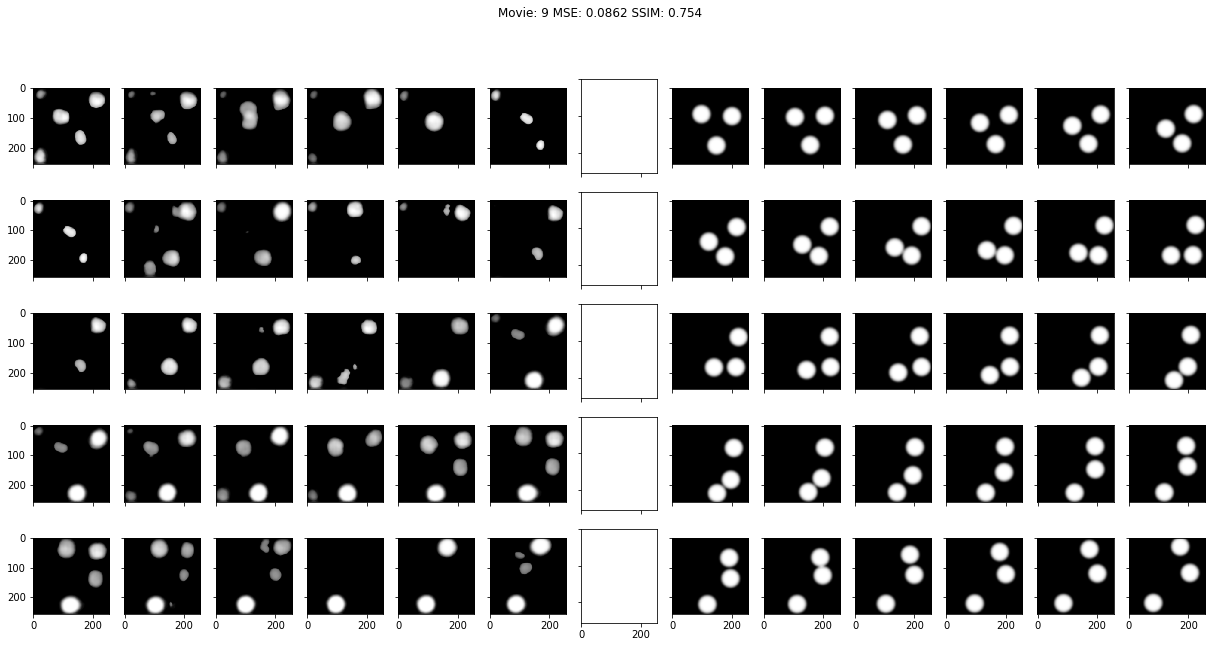

In [53]:
show_video(test_preds,My_test,min_ssim_ind,save=True,filename='worst_test.png')

In [40]:
y_train_pred = CUPNET2.predict(np.reshape(MX_train[0:3],(3,100,256,256,1)))
for i in range(3,68,3):
    if i < 67:
        ytp = CUPNET2.predict(np.reshape(MX_train[i:i+3],(3,100,256,256,1)))
    else:
        ytp = CUPNET2.predict(np.reshape(MX_train[i:]))
    y_train_pred = np.concatenate([y_train_pred,ytp])

np.save('D:/Matt/full_vid_train_preds',y_train_pred)
    

In [43]:
My_train = My_train.astype('float32')
y_train_pred = y_train_pred.astype('float32')
ssims2 = []
for i in range(70):
    ssim_l = np.mean(tf.image.ssim(tf.convert_to_tensor(y_train_pred[i]),tf.convert_to_tensor(My_train[i]),1))
    ssims2.append(ssim_l)

IndexError: index 69 is out of bounds for axis 0 with size 69

In [47]:
min_ssim2_ind = np.argmin(ssims2)
max_ssim2_ind = np.argmax(ssims2)
ssims2[min_ssim2_ind]

0.7797498

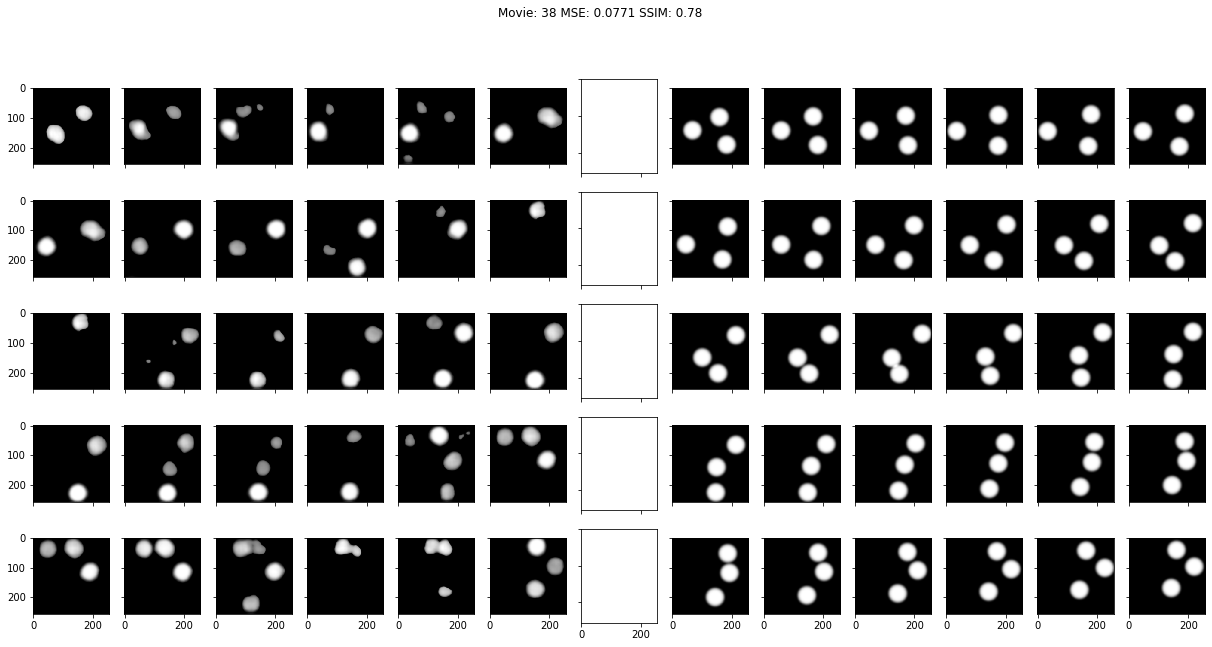

In [51]:
show_video(y_train_pred.astype('float32'),My_train.astype('float32'),min_ssim2_ind,save=True, filename = 'worst_train.png')

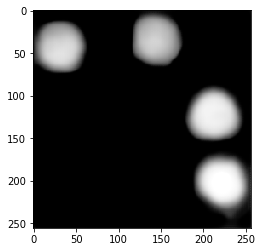

In [19]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(y_test_pred[0],(100,256,256))[99],cmap='gray')

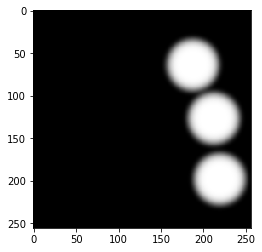

In [14]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(My_test[0],(100,256,256))[99],cmap='gray')